# Meta-Model Structure Selection (MetaMSS) algorithm for building Polynomial NARX models

Example created by Wilson Rocha Lacerda Junior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import MetaMSS, FROLS
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.parameter_estimation import RecursiveLeastSquares
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

<Axes: >

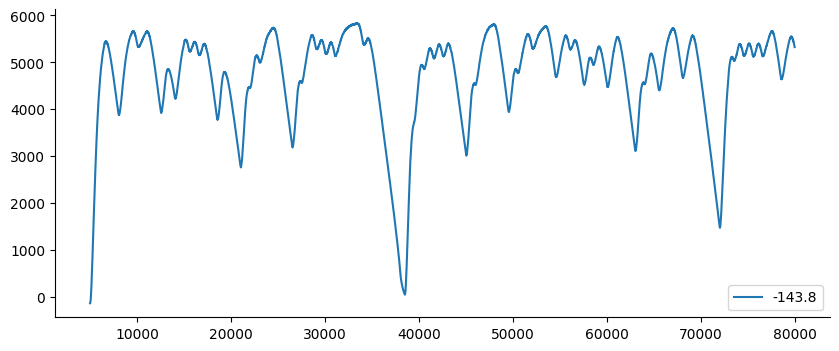

In [2]:
df1 = pd.read_csv("./datasets/x_cc.csv")
df2 = pd.read_csv("./datasets/y_cc.csv")

df2[5000:80000].plot(figsize=(10, 4))

In [3]:
df1.iloc[::500].values.shape

(1000, 1)

We will decimate the data using d=500 in this example.
Besides, we separate the MetaMSS data to use the same amount of samples in the prediction validation. Because MetaMSS need a train and test data to optimize the parameters of the model, in this case, we'll use 400 samples to train instead of 500 samples used for the other models. 

In [7]:
# we will decimate the data using d=500 in this example
x_train, x_test = np.split(df1.iloc[::500].values, 2)
y_train, y_test = np.split(df2.iloc[::500].values, 2)

In [65]:
basis_function = Polynomial(degree=2)
estimator = RecursiveLeastSquares()

model = MetaMSS(
    xlag=5,
    ylag=5,
    estimator=estimator,
    maxiter=5,
    n_agents=15,
    basis_function=basis_function,
    random_state=42,
)

model.fit(X=x_train, y=y_train)

c:\Users\wilso\miniconda3\envs\sysidentpy334\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\wilso\miniconda3\envs\sysidentpy334\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\meta_model_structure_selection.py:455: RuntimeWarning: overflow encountered in square
  sum_of_squared_residues = np.sum(residues**2)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\meta_model_structure_selection.py:465: RuntimeWarning: invalid value encountered in sqrt
  se_theta = np.sqrt(var_e)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\metrics\_regression.py:216: RuntimeWarning: overflow encountered in square
  numerator = np.sum(np.square((yhat

0.035919583498004094
        Regressors   Parameters             ERR
0                1  -6.1606E+02  0.00000000E+00
1           y(k-1)   1.3117E+00  0.00000000E+00
2           y(k-2)  -3.0579E-01  0.00000000E+00
3          x1(k-1)   5.7920E+02  0.00000000E+00
4          x1(k-3)  -1.8750E-01  0.00000000E+00
5    x1(k-1)y(k-1)  -1.7305E-01  0.00000000E+00
6    x1(k-2)y(k-1)  -1.1660E-01  0.00000000E+00
7    x1(k-1)y(k-2)   1.2182E-01  0.00000000E+00
8    x1(k-2)y(k-2)   3.4112E-02  0.00000000E+00
9    x1(k-1)y(k-3)  -4.8970E-02  0.00000000E+00
10   x1(k-1)y(k-4)   1.3846E-02  0.00000000E+00
11       x1(k-2)^2   1.0290E+02  0.00000000E+00
12  x1(k-3)x1(k-2)   8.6745E-01  0.00000000E+00
13  x1(k-4)x1(k-2)   3.4336E-01  0.00000000E+00
14  x1(k-5)x1(k-2)   2.7815E-01  0.00000000E+00
15       x1(k-3)^2  -9.3749E-01  0.00000000E+00
16  x1(k-4)x1(k-3)   6.1039E-01  0.00000000E+00
17  x1(k-5)x1(k-3)   3.9361E-02  0.00000000E+00
18       x1(k-4)^2  -4.6335E-01  0.00000000E+00
19  x1(k-5)x1(k-4) 

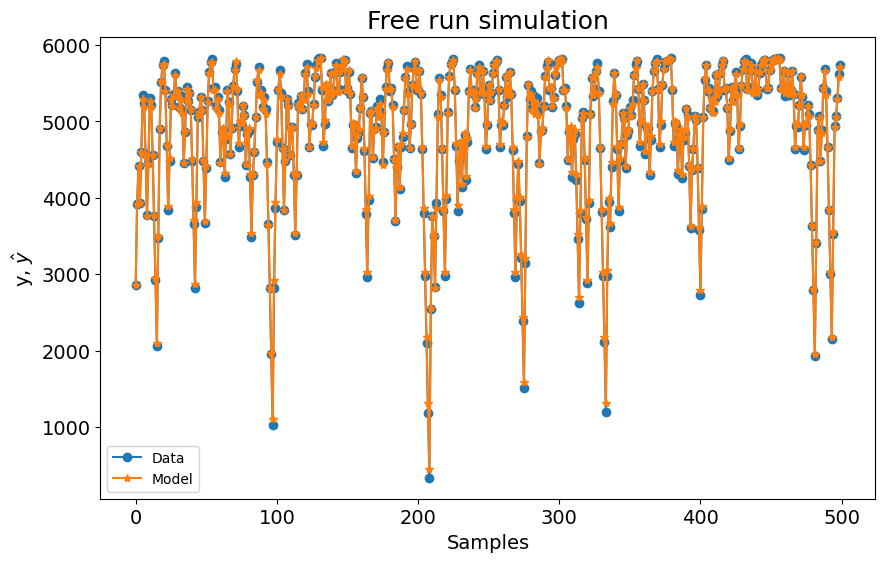

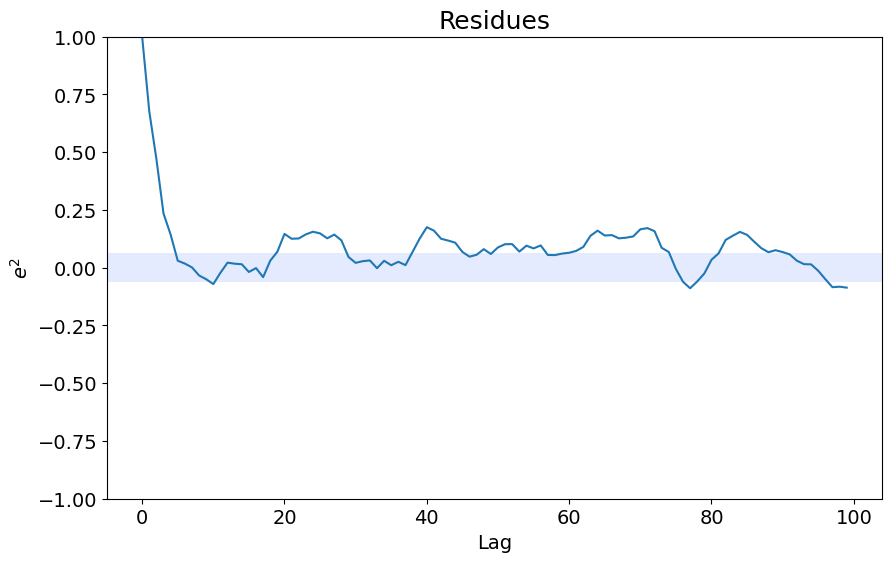

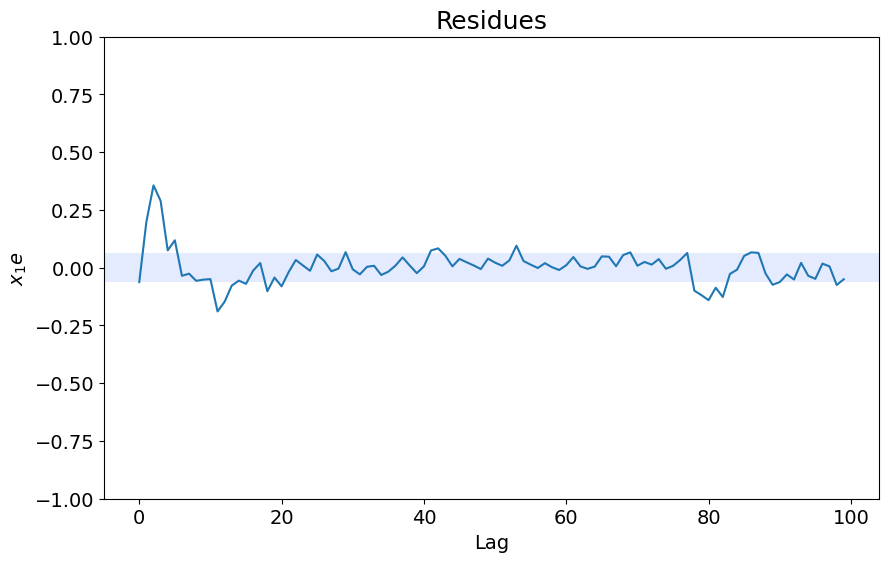

In [67]:
yhat = model.predict(X=x_test, y=y_test, steps_ahead=None)
rrse = root_relative_squared_error(y_test[model.max_lag :, :], yhat[model.max_lag :, :])
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

plot_results(y=y_test, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_test, yhat, x_test)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

0.0017530517788608157

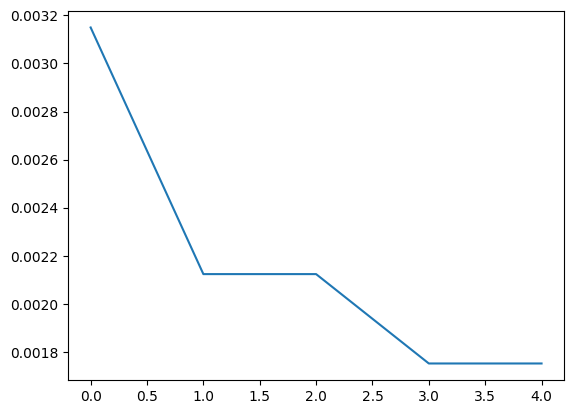

In [68]:
# Plotting the evolution of the agents
plt.plot(model.best_by_iter)
model.best_by_iter[-1]

In [69]:
# You have access to all tested models
# model.tested_models

In [74]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ARDRegression
from sysidentpy.general_estimators import NARX

xlag = ylag = 5

estimators = [
    (
        "NARX_KNeighborsRegressor",
        NARX(
            base_estimator=KNeighborsRegressor(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX_DecisionTreeRegressor",
        NARX(
            base_estimator=DecisionTreeRegressor(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX_RandomForestRegressor",
        NARX(
            base_estimator=RandomForestRegressor(n_estimators=200),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX_Catboost",
        NARX(
            base_estimator=CatBoostRegressor(
                iterations=800, learning_rate=0.1, depth=8
            ),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
            fit_params={"verbose": False},
        ),
    ),
    (
        "NARX_ARD",
        NARX(
            base_estimator=ARDRegression(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "FROLS-Polynomial_NARX",
        FROLS(
            order_selection=True,
            n_info_values=50,
            ylag=ylag,
            xlag=xlag,
            basis_function=basis_function,
            info_criteria="bic",
            err_tol=None,
        ),
    ),
    (
        "MetaMSS",
        MetaMSS(
            norm=-2,
            xlag=xlag,
            ylag=ylag,
            estimator=estimator,
            maxiter=5,
            n_agents=15,
            loss_func="metamss_loss",
            basis_function=basis_function,
            random_state=42,
        ),
    ),
]


resultados = {}
for nome_do_modelo, modelo in estimators:
    resultados["%s" % (nome_do_modelo)] = []
    modelo.fit(X=x_train, y=y_train)
    yhat = modelo.predict(X=x_test, y=y_test)
    if nome_do_modelo in ["FROLS-Polynomial_NARX", "MetaMSS"]:
        result = root_relative_squared_error(
            y_test[modelo.max_lag :], yhat[modelo.max_lag :]
        )
    else:
        result = root_relative_squared_error(y_test, yhat)
    resultados["%s" % (nome_do_modelo)].append(result)
    print(nome_do_modelo, "%.3f" % np.mean(result))

NARX_KNeighborsRegressor 1.158
NARX_DecisionTreeRegressor 0.203
NARX_RandomForestRegressor 0.146
NARX_Catboost 0.120
NARX_ARD 0.083
FROLS-Polynomial_NARX 0.057


c:\Users\wilso\miniconda3\envs\sysidentpy334\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\wilso\miniconda3\envs\sysidentpy334\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\meta_model_structure_selection.py:455: RuntimeWarning: overflow encountered in square
  sum_of_squared_residues = np.sum(residues**2)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\meta_model_structure_selection.py:465: RuntimeWarning: invalid value encountered in sqrt
  se_theta = np.sqrt(var_e)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\metrics\_regression.py:216: RuntimeWarning: overflow encountered in square
  numerator = np.sum(np.square((yhat

MetaMSS 0.036


In [75]:
for model_name, metric in sorted(
    resultados.items(), key=lambda x: np.mean(x[1]), reverse=False
):
    print(model_name, np.mean(metric))

MetaMSS 0.035919583498004094
FROLS-Polynomial_NARX 0.05729765719062527
NARX_ARD 0.08265856190495872
NARX_Catboost 0.12034851661643597
NARX_RandomForestRegressor 0.14557973585496042
NARX_DecisionTreeRegressor 0.203057724881072
NARX_KNeighborsRegressor 1.157787546845798
